In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
USER     = 'root'
PASSWORD = 'navya'
HOST     = 'localhost'
DB       = 'ecommerce'

engine = create_engine(
    f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}/{DB}?charset=utf8mb4",
    pool_pre_ping=True
)

<h3>List all unique cities where customers are located</h3>

In [3]:
query = text("""
    SELECT DISTINCT customer_city
    FROM customers
""")
df_cities = pd.read_sql(query, engine)
df_cities.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


<h3>Count the number of orders placed in 2017</h3>

In [4]:
query = text("""
    SELECT COUNT(order_id) AS total_orders
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2017
""")
df_orders_2017 = pd.read_sql(query, engine)
print(f"Total orders placed in 2017: {df_orders_2017.at[0,'total_orders']}")

Total orders placed in 2017: 45101


<h3>Find the total sales per category</h3>

In [5]:
query = text("""
    SELECT UPPER(p.product_category) AS category,
           ROUND(SUM(pay.payment_value),2) AS sales
      FROM products p
      JOIN order_items oi ON p.product_id = oi.product_id
      JOIN payments pay ON pay.order_id = oi.order_id
  GROUP BY category
""")
df_sales_cat = pd.read_sql(query, engine)
df_sales_cat.head()

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


<h3>Calculate the % of orders paid in installments</h3>

In [6]:
query = text("""
    SELECT ROUND(
      100.0 * SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)
      / COUNT(*),
      4
    ) AS pct_installments
    FROM payments
""")
df_pct_inst = pd.read_sql(query, engine)
print(f"% paid in installments: {df_pct_inst.at[0,'pct_installments']}%")

% paid in installments: 99.9981%


<h3>Count customers by state & bar chart</h3>

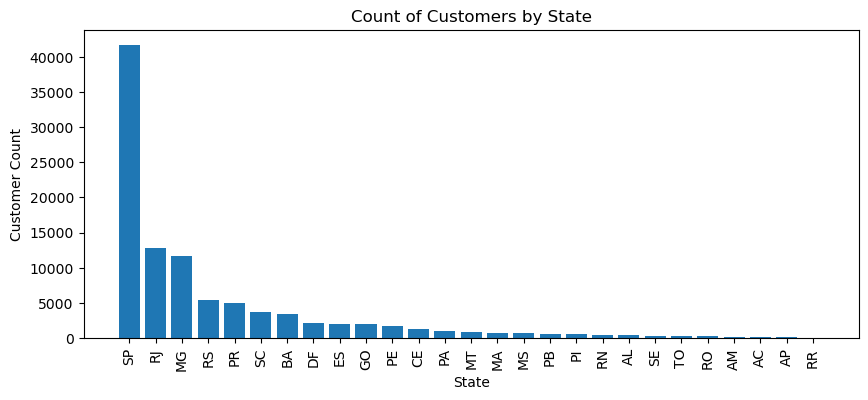

In [7]:
query = text("""
    SELECT customer_state AS state,
           COUNT(*) AS customer_count
      FROM customers
  GROUP BY customer_state
  ORDER BY customer_count DESC
""")
df_states = pd.read_sql(query, engine)

plt.figure(figsize=(10,4))
plt.bar(df_states['state'], df_states['customer_count'])
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Customer Count')
plt.title('Count of Customers by State')
plt.show()

<h3>Orders per month in 2018</h3>

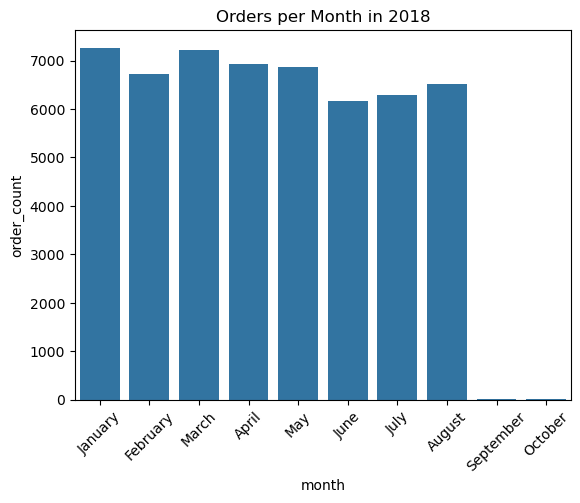

In [8]:
query = text("""
    SELECT MONTHNAME(order_purchase_timestamp) AS month,
           COUNT(order_id) AS order_count
      FROM orders
     WHERE YEAR(order_purchase_timestamp) = 2018
  GROUP BY month
""")
df_2018 = pd.read_sql(query, engine)
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

sns.barplot(
    x='month', y='order_count', data=df_2018,
    order=[m for m in month_order if m in df_2018['month'].tolist()]
)
plt.xticks(rotation=45)
plt.title('Orders per Month in 2018')
plt.show()

<h3>Avg number of products per order, by customer city</h3>

In [9]:
query = text("""
WITH count_per_order AS (
  SELECT o.order_id,
         o.customer_id,
         COUNT(oi.product_id) AS num_items
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY o.order_id, o.customer_id
)
SELECT c.customer_city,
       ROUND(AVG(cpo.num_items),2) AS avg_items_per_order
  FROM customers c
  JOIN count_per_order cpo
    ON c.customer_id = cpo.customer_id
 GROUP BY c.customer_city
 ORDER BY avg_items_per_order DESC
""")
df_avg_items = pd.read_sql(query, engine)
df_avg_items.head(10)

,customer_city,avg_items_per_order
0,padre carvalho,7.0
1,celso ramos,6.5
2,datas,6.0
3,candido godoi,6.0
4,matias olimpio,5.0
5,cidelandia,4.0
6,picarra,4.0
7,morro de sao paulo,4.0
8,teixeira soares,4.0
9,curralinho,4.0


<h3> % of total revenue by product category</h3>

In [10]:
query = text("""
SELECT UPPER(p.product_category) AS category,
       ROUND(
         100 * SUM(pay.payment_value)
             / (SELECT SUM(payment_value) FROM payments),
         2
       ) AS pct_revenue
  FROM products p
  JOIN order_items oi ON p.product_id = oi.product_id
  JOIN payments pay ON pay.order_id = oi.order_id
 GROUP BY category
 ORDER BY pct_revenue DESC
""")
df_pct_rev = pd.read_sql(query, engine)
df_pct_rev.head()

,category,pct_revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


<h3>Correlation between product price and purchase count by category</h3>

In [11]:
query = text("""
SELECT p.product_category    AS category,
       COUNT(oi.product_id)   AS order_count,
       ROUND(AVG(oi.price),2) AS avg_price
  FROM products p
  JOIN order_items oi ON p.product_id = oi.product_id
 GROUP BY p.product_category
""")
df_corr = pd.read_sql(query, engine)

corr_val = df_corr['order_count'].corr(df_corr['avg_price'])
print("Correlation:", corr_val)

Correlation: -0.10631514167157562


<h3>Total revenue by seller, ranked</h3>

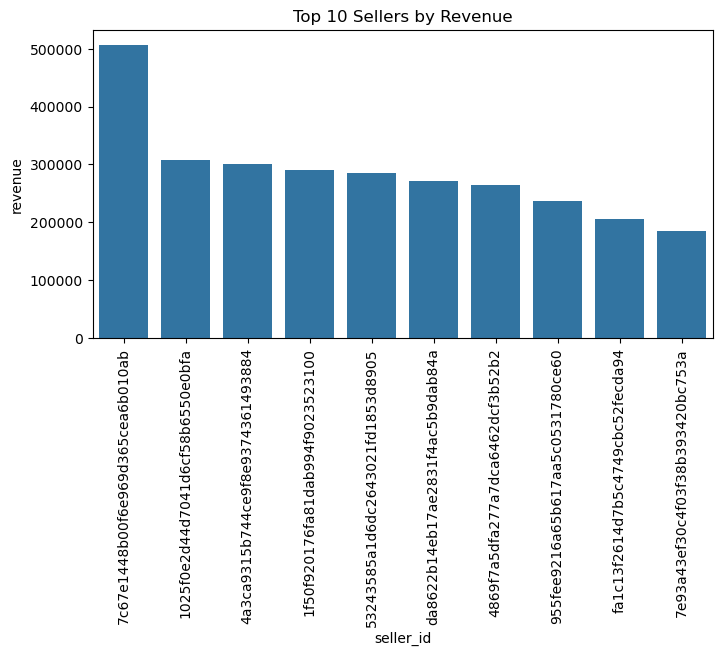

In [12]:
query = text("""
SELECT seller_id,
       SUM(pay.payment_value) AS revenue
  FROM order_items oi
  JOIN payments pay ON oi.order_id = pay.order_id
 GROUP BY seller_id
""")
df_seller = pd.read_sql(query, engine)
df_seller = df_seller.sort_values('revenue', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,4))
sns.barplot(x='seller_id', y='revenue',
            data=df_seller.head(10))
plt.xticks(rotation=90)
plt.title('Top 10 Sellers by Revenue')
plt.show()

<h3>Moving average of order values per customer</h3>

In [13]:
query = text("""
SELECT customer_id,
       order_purchase_timestamp,
       payment_value,
       AVG(payment_value)
         OVER (
           PARTITION BY customer_id
           ORDER BY order_purchase_timestamp
           ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
         ) AS mov_avg
  FROM (
    SELECT o.customer_id,
           o.order_purchase_timestamp,
           pay.payment_value
      FROM orders o
      JOIN payments pay ON o.order_id = pay.order_id
  ) AS sub
""")
df_movavg = pd.read_sql(query, engine)
df_movavg.head()

,customer_id,order_purchase_timestamp,payment_value,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


<h3>Cumulative sales per month for each year</h3>

In [14]:
query = text("""
WITH monthly AS (
  SELECT
    YEAR(o.order_purchase_timestamp) AS yr,
    MONTH(o.order_purchase_timestamp) AS mon,
    ROUND(SUM(pay.payment_value),2)         AS sales
  FROM orders o
  JOIN payments pay ON o.order_id = pay.order_id
 GROUP BY yr, mon
)
SELECT *,
       SUM(sales) OVER (ORDER BY yr, mon) AS cum_sales
  FROM monthly
""")
df_cum = pd.read_sql(query, engine)
df_cum.head()

,yr,mon,sales,cum_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


<h3>Year‑over‑year growth rate of total sales</h3>

In [15]:
query = text("""
WITH yearly AS (
  SELECT
    YEAR(o.order_purchase_timestamp) AS yr,
    ROUND(SUM(pay.payment_value),2)         AS total_sales
  FROM orders o
  JOIN payments pay ON o.order_id = pay.order_id
 GROUP BY yr
)
SELECT
  yr,
  ROUND(
    100 * (total_sales - LAG(total_sales) OVER (ORDER BY yr))
          / LAG(total_sales) OVER (ORDER BY yr),
    2
  ) AS yoy_growth_pct
FROM yearly
""")
df_yoy = pd.read_sql(query, engine)
df_yoy

,yr,yoy_growth_pct
0,2016,NaN
1,2017,12112.7
2,2018,20.0


<h3>Retention rate (another purchase within 6 months of first order)</h3>

In [16]:
query = text("""
WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id,
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders ON orders.customer_id = a.customer_id
               AND orders.order_purchase_timestamp > a.first_order
               AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT
    ROUND(
        100.0 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id),
        2
    ) AS retention_pct
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;
""")

df_ret = pd.read_sql(query, engine)
print(df_ret)

   retention_pct
0            0.0


<h3>Top 3 customers by spend each year</h3>

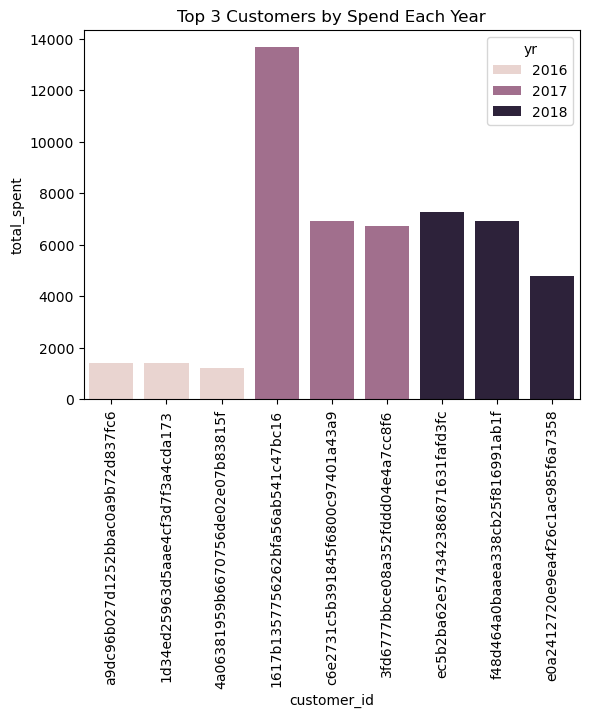

In [17]:
query = text("""
WITH yearly_spend AS (
  SELECT
    YEAR(o.order_purchase_timestamp) AS yr,
    o.customer_id,
    SUM(pay.payment_value)        AS total_spent,
    DENSE_RANK() OVER (
      PARTITION BY YEAR(o.order_purchase_timestamp)
      ORDER BY SUM(pay.payment_value) DESC
    )                       AS rank_in_year
  FROM orders o
  JOIN payments pay ON o.order_id = pay.order_id
 GROUP BY yr, o.customer_id
)
SELECT yr, customer_id, total_spent
  FROM yearly_spend
 WHERE rank_in_year <= 3
""")
df_top3 = pd.read_sql(query, engine)

# plt.figure(figsize=(8,4))
sns.barplot(x='customer_id', y='total_spent',
            hue='yr', data=df_top3)
plt.xticks(rotation=90)
plt.title('Top 3 Customers by Spend Each Year')
plt.show()